# Importing libraries

In [1]:
import sys
sys.path.insert(1, '../')


importing Uni-ACS open source libraries

In [4]:
import importlib
import medical_explainer
importlib.reload(medical_explainer)


<module 'medical_explainer' from '/Users/ahsueh/Documents/GA Tech/BD4H/Uni-ACS/mimiciv_sepsis_mortality/../medical_explainer.py'>

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Formatting Data

Using features and dataset from 

In [5]:
import pandas as pd
data = pd.read_csv('mimiciv_sepsis.csv').drop(['testtrain', 'hadm_id'], axis=1)

data['gender'] = data['gender'].apply(lambda x: 1 if x == 'M' else 0)

data = pd.concat([data, pd.get_dummies(data['marital_status'], prefix='marital_status')], axis=1)
data = data.drop(['marital_status'], axis=1)

data = pd.concat([data, pd.get_dummies(data['ethnicity'], prefix='ethnicity')], axis=1)
data = data.drop(['ethnicity'], axis=1)

data = pd.concat([data, pd.get_dummies(data['insurance'], prefix='insurance')], axis=1)
data = data.drop(['insurance'], axis=1)

data = pd.concat([data, pd.get_dummies(data['ed_medgp_antibiotic_hrgp'], prefix='antibiotic')], axis=1)
data = data.drop(['ed_medgp_antibiotic_hrgp'], axis=1)

# Train Test Splits

In [78]:
from sklearn.model_selection import train_test_split

seed = 7

X = data.drop(['icu_adm_flag', 'hosdeath_flag'], axis=1)
y = data['hosdeath_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed)


In [79]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_train)

X_train = pd.DataFrame(imp.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(imp.transform(X_test), columns=X.columns)

In [80]:
print(len(X_train))
print(len(X_test))

5383
2307


# Fit Classifiers, Random Forest & Logistic Regression

Random Forest parameters
- n_estimators = 200
- max_depth=5

Logistic Regression parameters
- solver='liblinear'

------------------------------
Classifier: Random Forest
ROC AUC: 0.8868159059152306
Average Precision: 0.4352523043058239
Accuracy: 0.9306458604247941

| Step 1  ==> Calibrating model


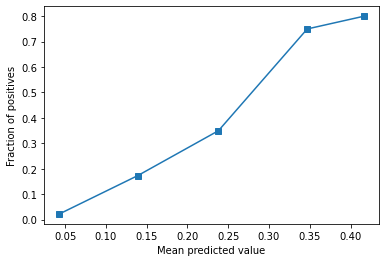

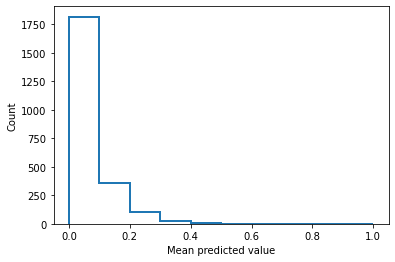

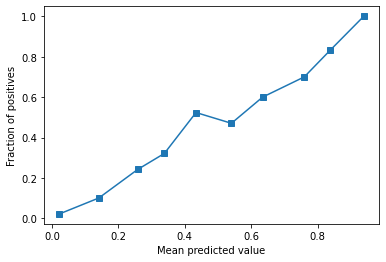

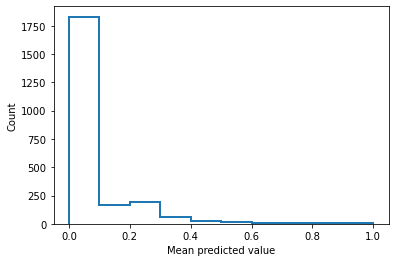

ROC AUC: 0.8868159059152306
Average Precision: 0.4352523043058239
Accuracy: 0.9306458604247941
ROC AUC: 0.8850474499301351
Average Precision: 0.4309332418530647
Accuracy: 0.9358474208929346

| Step 2 ==> Calculate SHAP values

| Step 3 ==> Fit clinical score calculator
Novel fitting


Probability threshold: 0.1
Score threshold: 26.0

Probability threshold: 0.5
Score threshold: 63.0

Probability threshold: 0.9
Score threshold: 63.0

Explainer ROC AUC: 0.8460045994410806
Explainer Average Precision: 0.32925287818859394
Explainer Accuracy: 0.9306458604247941
[[2145    2]
 [ 158    2]]

AUC Drop: 4.602004339562566
Accuracy Drop: 0.0

------------------------------
Classifier: Logistic Regression
ROC AUC: 0.8737831858407079
Average Precision: 0.43729829238880497
Accuracy: 0.9328131772865192

| Step 1  ==> Calibrating model


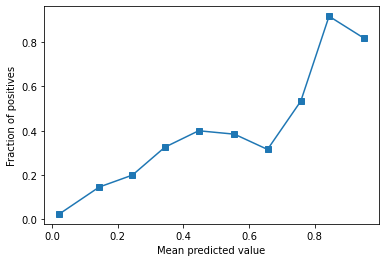

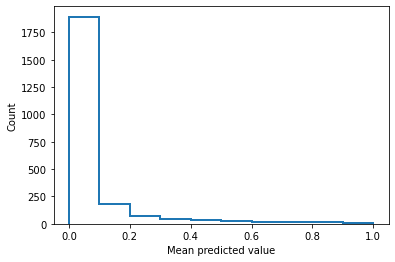

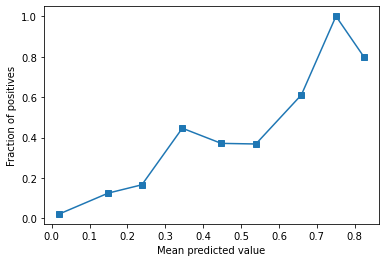

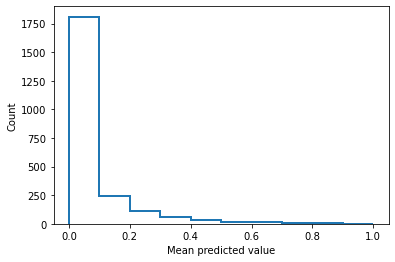

ROC AUC: 0.8737831858407079
Average Precision: 0.43729829238880497
Accuracy: 0.9328131772865192
ROC AUC: 0.874656497438286
Average Precision: 0.43193355930176625
Accuracy: 0.9354139575205895

| Step 2 ==> Calculate SHAP values

| Step 3 ==> Fit clinical score calculator
Novel fitting


Probability threshold: 0.1
Score threshold: 29.0

Probability threshold: 0.5
Score threshold: 41.0

Probability threshold: 0.9
Score threshold: 44.0

Explainer ROC AUC: 0.780548439683279
Explainer Average Precision: 0.22748727909661723
Explainer Accuracy: 0.929778933680104
[[2145    2]
 [ 160    0]]

AUC Drop: 10.670238071441412
Accuracy Drop: 0.32527881040892037



In [152]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Random Forest
clf_rf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=seed)
clf_rf.fit(X_train, y_train)

# Logistic Regression
estimators = [('Scaler', StandardScaler()), ('Log_Reg', LogisticRegression(random_state=seed, solver='liblinear'))]
pipe = Pipeline(estimators)
clf_logReg = pipe.fit(X_train, y_train)

classifiers = [clf_rf, clf_logReg]
clf_labels = ['Random Forest', 'Logistic Regression']
shap_methods = ['tree', 'linear']

auc_orig = []
prec_orig = []
acc_orig = []
explainers = []

for i, clf in enumerate(classifiers):
    print("------------------------------")
    print("Classifier: " + clf_labels[i])
    roc_auc_orig = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    auc_orig.append(roc_auc_orig)
    print("ROC AUC: " + str(roc_auc_orig))

    average_precision_orig = average_precision_score(y_test, clf.predict_proba(X_test)[:, 1])
    prec_orig.append(average_precision_orig)
    print("Average Precision: " + str(average_precision_orig))

    accuracy_orig = accuracy_score(y_test, clf.predict(X_test))
    acc_orig.append(accuracy_orig)
    print("Accuracy: " + str(accuracy_orig))
    print('')
    
    explainer = medical_explainer.explainer(
        clf, X_train, y_train, X_test, y_test)

    explainer.fit(10, shap_method=shap_methods[i], method='novel', calculator_threshold=0.0001)

    explainers.append(explainer)
    
    scores,probs,predictions = explainer.predict_calculator(X_test, 1)
    
    roc_auc = roc_auc_score(y_test, probs)
    print("Explainer ROC AUC: " + str(roc_auc))

    average_precision = average_precision_score(y_test, probs)
    print("Explainer Average Precision: " + str(average_precision))

    # accuracy = accuracy_score(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)
    print("Explainer Accuracy: " + str(accuracy))

    # print(confusion_matrix(y_test, predictions))
    print(confusion_matrix(y_test, predictions))
    
    # AUC DROP (percentage)
    print('')
    auc_drop = ((auc_orig[i] - roc_auc) / auc_orig[i]) * 100
    print("AUC Drop: " + str(auc_drop))

    # ACCURACY DROP (percentage)
    acc_drop = ((acc_orig[i] - accuracy) / acc_orig[i]) * 100
    print("Accuracy Drop: " + str(acc_drop))
    print('')

# Resulting UNI-ACS attributes 

In [153]:
explainer.shap_array_list

[[0.8906482766616688, -0.787508099078455],
 [-0.5971831318282295, 0.5350279895351713],
 [-0.43127086891775285, 0.43999176970262466],
 [-0.37729665791391526, 0.4795891400941728],
 [-0.42971810504171853, 0.378057532278022],
 [-0.2473757608547028, 0.43195673446168165],
 [-0.21466205704333832, 0.6109612392771939],
 [-0.2835278094422935, 0.236537692221597],
 [-0.24898486787962104, 0.22883747584461236],
 [-0.17534173722441496, 0.3036427757569707]]

In [154]:
explainers[0].score_array_list

[array([-3., 13.]),
 array([-2.,  4.]),
 array([ 0., -2.,  5.]),
 array([ 0., -2.,  6.]),
 array([ 4., -2.]),
 array([ 2., -1.]),
 array([-1.,  4.]),
 array([-1.,  2.]),
 array([-1.,  4.]),
 array([ 3., -1.])]

In [155]:
explainers[1].score_array_list

[array([ 5., -4.]),
 array([-3.,  3.]),
 array([-2.,  3.]),
 array([-2.,  3.]),
 array([-2.,  2.]),
 array([-1.,  2.]),
 array([-1.,  3.]),
 array([-2.,  1.]),
 array([-1.,  1.]),
 array([-1.,  2.])]

In [156]:
explainers[0].scoring_table

,Score,Probability
0,0.0,0.040311
1,1.0,0.041741
2,2.0,0.043219
3,3.0,0.044748
4,4.0,0.046328
...,...,...
59,59.0,0.264021
60,60.0,0.271145
61,61.0,0.278388
62,62.0,0.285750


In [157]:
explainers[1].scoring_table

,Score,Probability
0,0.0,0.000672
1,1.0,0.000801
2,2.0,0.000955
3,3.0,0.001137
4,4.0,0.001355
5,5.0,0.001614
6,6.0,0.001923
7,7.0,0.002291
8,8.0,0.002728
9,9.0,0.003250


In [142]:
explainers[0].variables

array(['time2bg_24hr_flag', 'chem24hr_bun_first', 'edvital_sbp_min',
       'edvital_resprate_median', 'edvital_resprate_max',
       'fbc24hr_rdw_first', 'charlson_comorbidity_index',
       'edvital_sbp_median', 'antibiotic_a_lesse1', 'fbc24hr_wbc_first'],
      dtype=object)

In [144]:
explainers[1].variables

array(['fbc24hr_hemoglobin_first', 'fbc24hr_hematocrit_first',
       'fbc24hr_mcv_first', 'edvital_heartrate_median', 'age',
       'edvital_resprate_median', 'time2bg_24hr_flag',
       'fbc24hr_mchc_first', 'fbc24hr_rbc_first', 'fbc24hr_rdw_first'],
      dtype=object)

In [143]:
explainers[0].breakpoints_list

[[0.0, 0.20181586643365568, 1.0],
 [2.0, 29.194533059925824, 209.0],
 [4.0, 97.44824410910586, 187.48916799086862, 202.0],
 [9.0, 10.298288416082466, 21.705185416258, 62.0],
 [12.0, 15.058674688750425, 25.163313325427506, 165.0],
 [11.0, 16.18370120857321, 29.2],
 [0.0, 6.791061016460162, 20.0],
 [10.0, 107.00658077228563, 212.0],
 [0.0, 0.19859734759740139, 1.0],
 [0.1, 4.21606550344877, 12.912925636124646, 216.3]]

In [145]:
explainers[1].breakpoints_list

[[3.9, 11.276245537789539, 19.0],
 [10.6, 34.138457585367476, 58.2],
 [60.0, 91.68131376781446, 134.0],
 [39.0, 86.2269368608841, 174.0],
 [18.0, 67.9511866883132, 98.0],
 [9.0, 19.469512432083924, 62.0],
 [0.0, 0.26489795991356724, 1.0],
 [24.2, 32.91054349446267, 38.8],
 [1.27, 3.7484872607454243, 7.05],
 [11.0, 14.734409278715148, 29.2]]